In [1]:
import pandas as pd

train_csv_path = "/content/sample_data/mnist_train_small.csv"
test_csv_path = "/content/sample_data/mnist_test.csv"

# Load CSV files into Pandas DataFrames
train_df = pd.read_csv(train_csv_path)
test_df = pd.read_csv(test_csv_path)

# information about the DataFrames
print("Training set shape:", train_df.shape)
print("Test set shape:", test_df.shape)

# first rows of DataFrames
print("\nTraining set:")
print(train_df.head())

print("\nTest set:")
print(test_df.head())


Training set shape: (19999, 785)
Test set shape: (9999, 785)

Training set:
   6  0  0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  ...  0.581  0.582  0.583  \
0  5  0    0    0    0    0    0    0    0    0  ...      0      0      0   
1  7  0    0    0    0    0    0    0    0    0  ...      0      0      0   
2  9  0    0    0    0    0    0    0    0    0  ...      0      0      0   
3  5  0    0    0    0    0    0    0    0    0  ...      0      0      0   
4  2  0    0    0    0    0    0    0    0    0  ...      0      0      0   

   0.584  0.585  0.586  0.587  0.588  0.589  0.590  
0      0      0      0      0      0      0      0  
1      0      0      0      0      0      0      0  
2      0      0      0      0      0      0      0  
3      0      0      0      0      0      0      0  
4      0      0      0      0      0      0      0  

[5 rows x 785 columns]

Test set:
   7  0  0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  ...  0.658  0.659  0.660  \
0  2  0    0    0    0    0    

In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class MNISTDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        label = torch.tensor(self.dataframe.iloc[idx, 0], dtype=torch.long)
        image = torch.tensor(self.dataframe.iloc[idx, 1:].values, dtype=torch.float32).view(1, 28, 28)  # Add the channel dimension

        if self.transform:
            # Convert the tensor to a PIL Image
            image = transforms.ToPILImage()(image)
            image = self.transform(image)

        return image, label

# Transformation
transform = transforms.Compose([transforms.Grayscale(num_output_channels=3),  # Convert to RGB
                                transforms.Resize((224, 224)),
                                transforms.ToTensor()])

# Create instances from MNISTDataset
train_dataset = MNISTDataset(train_df, transform=transform)
test_dataset = MNISTDataset(test_df, transform=transform)

# DataLoaders
batch_size = 64  # only for a batch
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:07<00:00, 71.2MB/s]


Epoch 1/5, Loss: 0.3790853010585752
Epoch 2/5, Loss: 0.06485086045088098
Epoch 3/5, Loss: 0.03930443969329063
Epoch 4/5, Loss: 0.031249025190537707
Epoch 5/5, Loss: 0.024342987793698586


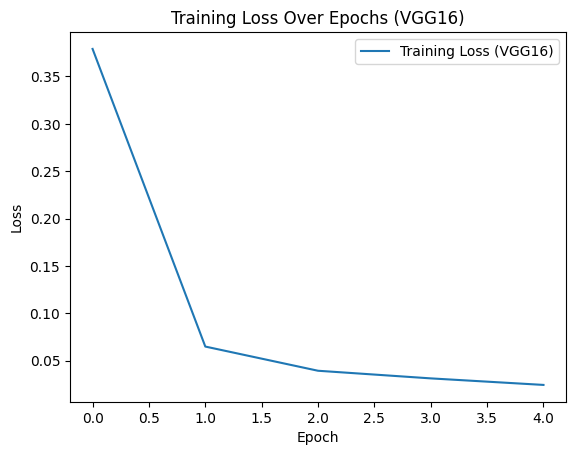

Accuracy on the test set (VGG16): 98.95%


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


data_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])



vgg16_model = models.vgg16(pretrained=True)

num_classes = len(set(train_df.iloc[:, 0]))
vgg16_model.classifier[6] = nn.Linear(4096, num_classes)


criterion_vgg16 = nn.CrossEntropyLoss()
optimizer_vgg16 = optim.SGD(vgg16_model.parameters(), lr=0.001, momentum=0.9)

# Train the fine-tuned VGG16 model
num_epochs = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg16_model = vgg16_model.to(device)

train_losses_vgg16 = []

for epoch in range(num_epochs):
    vgg16_model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer_vgg16.zero_grad()
        outputs = vgg16_model(inputs)
        loss = criterion_vgg16(outputs, labels)
        loss.backward()
        optimizer_vgg16.step()

        running_loss += loss.item()

    average_loss = running_loss / len(train_loader)
    train_losses_vgg16.append(average_loss)

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {average_loss}")

# Plotting the training loss curve for VGG16
plt.plot(train_losses_vgg16, label='Training Loss (VGG16)')
plt.title('Training Loss Over Epochs (VGG16)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Testing the fine-tuned VGG16 model
vgg16_model.eval()
correct_vgg16 = 0
total_vgg16 = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = vgg16_model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total_vgg16 += labels.size(0)
        correct_vgg16 += (predicted == labels).sum().item()

accuracy_vgg16 = correct_vgg16 / total_vgg16
print(f"Accuracy on the test set (VGG16): {100 * accuracy_vgg16:.2f}%")
